The use of deep learning in tabular data was not a new idea. People have been using fully-connected neural networks for these data for the longest time but it came with a few disadvantages;

Large amount of data needed for neural networks
Insignificant gains in model’s performance compared to more popular machine learning algorithms (e.g Random forest, Gradient boosting trees)
Lack of interpretability
As such, using deep learning for tabular data never really took off. This is true until practitioners transfer the idea of embedding networks used in Natural Language Processing (NLP) to tabular data.

This is how it works.

Traditionally, categorical variables such as ‘Gender’ or ‘Race’ were processed using One-hot encoding, where each entity in the variable was given a unique column to track the presence of the entity.

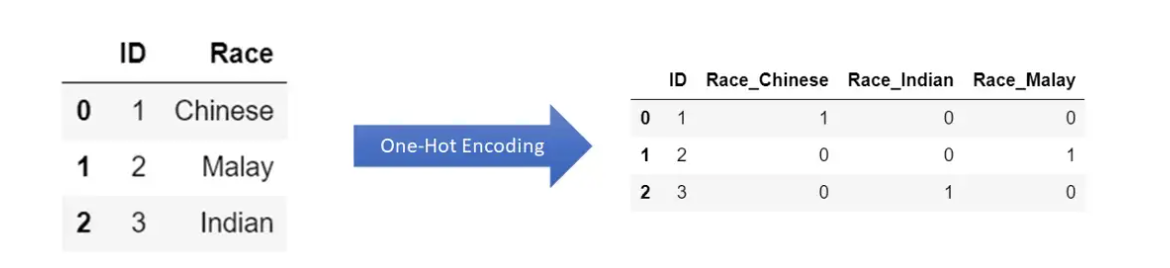

This method, although convert the data into a suitable format for machine learning algorithms, it assumes independence among entity and results in sparse matrices.

Entity embedding on the other hands uses a vector to represent each entity instead of a binary value. This has a few advantages;

Remove the sparse matrices problem of inefficient computation
Produce vectors that show the relationship between each entity (derive additional insights instead of treating them as independent)
 The dataset WE WILL use is the IEEE-CIS Fraud Detection data from Kaggle which you can find [here](https://www.kaggle.com/c/ieee-fraud-detection).

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
# define the neural networks
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras import Model

In [6]:
# import pandas as pd
train = pd.read_csv("Data/train_transaction.csv")
test = pd.read_csv("Data/test_transaction.csv")

In [7]:
train["isFraud"].mean() #  0.03499000914417313
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As data exploration and feature engineering is not the purpose of this post, I will use minimum features to predict the fraud label. To make sure you can replicate my code, here are my processing steps.

In [8]:
import numpy as np
# generate time of day
train["Time of Day"] = np.floor(train['TransactionDT']/3600/183)
test["Time of Day"] = np.floor(test['TransactionDT']/3600/183)

# drop columns
train.drop("TransactionDT",axis=1,inplace=True)
test.drop("TransactionDT",axis=1,inplace=True)

# define continuous and categorical variables
cont_vars = ["TransactionAmt"]
cat_vars = ['ProductCD','addr1','addr2','P_emaildomain','R_emaildomain','Time of Day'] + [col for col in train.columns if "card" in col]

# set training and testing set
x_train = train[cont_vars + cat_vars].copy()
y_train = train['isFraud'].copy()
x_test = train[cont_vars + cat_vars].copy()
y_test = train['isFraud'].copy()

# process cont_vars
# scale values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train['TransactionAmt'] = scaler.fit_transform(x_train['TransactionAmt'].values.reshape(-1,1))
x_test['TransactionAmt'] = scaler.transform(x_test['TransactionAmt'].values.reshape(-1,1))

# reduce cardinality of categorical variables
idx_list = x_train['card1'].value_counts()[x_train['card1'].value_counts()<=100].index.tolist()
x_train.loc[x_train['card1'].isin(idx_list),'card1'] = 'Others'
x_test.loc[x_test['card1'].isin(idx_list),'card1'] = 'Others'

# fill missing
x_train[cat_vars] = x_train[cat_vars].fillna("Missing")
x_test[cat_vars] = x_test[cat_vars].fillna("Missing")

After the processing steps have been done, now we can convert the categorical variables into integers.

In [9]:
# convert to numerical value for modeling
def categorify(df, cat_vars):
    categories = {}
    for cat in cat_vars:
        df[cat] = df[cat].astype('category').cat.as_ordered()
        categories[cat] = df[cat].cat.categories
    return categories

def apply_test(test,categories):
    for cat, index in categories.items():
        test[cat] = pd.Categorical(test[cat],categories=categories[cat],ordered=True)

# convert to integers
categories = categorify(x_train,cat_vars)
apply_test(x_test,categories)

for cat in cat_vars:
    # print(cat.dtypes)
    x_train[cat] = x_train[cat].astype('category').cat.codes+1 
    x_test[cat] = x_test[cat].astype('category').cat.codes+1

    # dat['street'] = dat['street_number'].astype(str).str.cat(dat['street_name'], sep=' ')

Due to the higly imbalanced dataset, I have to artificially generate more fraud data using a technique called Synthetic Minority Over-sampling Technique (SMOTE). The documentation can be found here.



In [10]:
# from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)

x_sm, y_train = sm.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_sm,columns=x_train.columns)

Finally, we can work on modelling the data. This implementation of the entity embedding took the idea and best practices from Jeremy Howard’s ‘Introduction to Machine Learning for Coders’ course. Hence, many of the technical specifics such as embedding sizes and hidden layers were selected by Jeremy through his research and experiences. Anyway, if you have not seen the course, I highly recommend you take the course and listen to Jeremy approach to machine learning. It is completely free too.

In [11]:
# get embedding size for each categorical variable

def get_emb_sz(cat_col,categories_dict):
    num_classes = len(categories_dict[cat_col])
    return int(min(600,round(1.6*num_classes**0.56)))

Now to define the neural networks. The architecture of the networks is simply the concatenation of continuous variables with embedding layers for each categorical variables.

In [12]:
# define the neural networks

def combined_network(cat_vars,categories_dict,cont_vars, layers):
    inputs = []
    embeddings = []
    emb_dict ={}

    # create embedding layer for each categorical variable
    for i in range(len(cat_vars)):
        emb_dict[cat_vars[i]] = Input(shape=(1,))
        emb_sz = get_emb_sz(cat_vars[i],categories_dict)
        vocab = len(categories_dict[cat_vars[i]]) +1
        embedding = Embedding(vocab,emb_sz,input_length=1)(emb_dict[cat_vars[i]])
        embedding = Reshape(target_shape=(emb_sz,))(embedding)
        inputs.append(emb_dict[cat_vars[i]])
        embeddings.append(embedding)

        # concat continuous variables with embedded variables
        cont_input = Input(shape=(len(cont_vars),))
        embedding = BatchNormalization()(cont_input)
        inputs.append(cont_input)
        embeddings.append(embedding)
        x = Concatenate()(embeddings)

  # add fully-connected layers separated with batchnorm and dropout layers
  
    for i in range(len(layers)):
        if i ==0:
          x = Dense(layers[i],activation='relu')(x)
        else:
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(layers[i],activation='relu')(x)

    output = Dense(1,activation='sigmoid')(x)
    model = Model(inputs,output)

    return model

Now initialize the model.

In [14]:
layers = [200,100]

model = combined_network(cat_vars,categories,cont_vars, layers)

opt = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

Process the input for the neural networks.

In [15]:
# process x_train input to fit model
input_list = []

for i in cat_vars:
    input_list.append(x_train[i].values)
    input_list.append(x_train[cont_vars].values)
  
# modify x_test input to fit model
test_list = []

for i in cat_vars:
    test_list.append(x_test[i].values)
    test_list.append(x_test[cont_vars].values)

Train the model.


In [16]:
model.fit(input_list,y_train,epochs=10)

Epoch 1/10
35618/35618 [==============================] - 272s 7ms/step - loss: 0.3832 - accuracy: 0.8263
Epoch 2/10
35618/35618 [==============================] - 248s 7ms/step - loss: 0.3045 - accuracy: 0.8698
Epoch 3/10
35618/35618 [==============================] - 255s 7ms/step - loss: 0.2788 - accuracy: 0.8832
Epoch 4/10
35618/35618 [==============================] - 234s 7ms/step - loss: 0.2626 - accuracy: 0.8909
Epoch 5/10
35618/35618 [==============================] - 218s 6ms/step - loss: 0.2515 - accuracy: 0.8960
Epoch 6/10
35618/35618 [==============================] - 174s 5ms/step - loss: 0.2432 - accuracy: 0.9000
Epoch 7/10
35618/35618 [==============================] - 188s 5ms/step - loss: 0.2372 - accuracy: 0.9030
Epoch 8/10
35618/35618 [==============================] - 169s 5ms/step - loss: 0.2322 - accuracy: 0.9051
Epoch 9/10
35618/35618 [==============================] - 168s 5ms/step - loss: 0.2278 - accuracy: 0.9072
Epoch 10/10
35618/35618 [=====================

Making prediction

In [17]:
y_pred = model.predict(test_list)
# choose an optimal threshold
y_pred = y_pred>0.1

18455/18455 [==============================] - 27s 1ms/step


Lastly, let's rank the solution using ROC-AUC.


In [18]:
roc = metrics.roc_auc_score(y_test,y_pred)
roc


0.8510757063953209

Not that bad for a model using only some of the features.

This is it. Using entity embedding for Kaggle tabular data competition. Hope you enjoy it.